In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd

### Bridge2AI dataset

In [2]:
dataset = VBAIDataset('./bids_without_sensitive_recordings')

### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)

train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 142
val: 18
test: 18


### Create PyTorch dataset of prolonged vowel audios with age and airway stenosis labels

In [4]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [5]:
class MySpecgramDataset(torch.utils.data.Dataset):
	def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
		self.segment_size = segment_size
		
		# get age and airway stenosis classification for all subjects
		participant_df = dataset.load_and_pivot_questionnaire('participant')
		age_df = participant_df[['record_id', 'age']].to_numpy()
		airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        
		age_dict = {}
		for person_id, age in age_df:
			age_dict[str(person_id)] = float(age)
		airway_stenosis_dict = {}
		for person_id, airway_stenosis in airway_stenosis_df:
			airway_stenosis_dict[str(person_id)] = float(airway_stenosis)

		# get all prolonged vowel audios
		self.audio_files = []
		self.age = []
		self.airway_stenosis = []
        
		for person_id, session_id in person_session_pairs:
			if person_id not in identities:
				continue
			vowel_audios = [str(x) for x in dataset.find_audio(person_id, session_id) if str(x).endswith('-Prolonged-vowel.wav')]
			self.audio_files += vowel_audios
			self.age += [age_dict[person_id]]*len(vowel_audios)
			self.airway_stenosis += [airway_stenosis_dict[person_id]]*len(vowel_audios)

	def __len__(self):
		return len(self.audio_files)

	def __getitem__(self, idx):
		audio = Audio.from_file(self.audio_files[idx])
		audio = audio.to_16khz()
		# get middle K seconds if audio is too long, pad with zeros if it is too short
		if audio.signal.size(0) > self.segment_size*16000:
			d = (audio.signal.size(0)-self.segment_size*16000)//2
			audio.signal = audio.signal[d:d+self.segment_size*16000]
		else:
			audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)

		win_length = 30
		hop_length = 10
		nfft = 512
		features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
		features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T

		return {'signal': features_specgram, 'age': self.age[idx], 'airway_stenosis': self.airway_stenosis[idx]}

tensor([58., 79., 55., 79., 69., 82., 46., 62.], dtype=torch.float64) tensor([0., 0., 1., 0., 0., 0., 1., 1.], dtype=torch.float64)


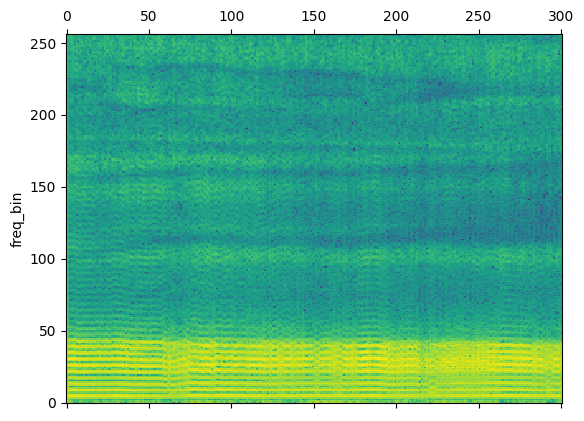

In [6]:
train_dataset = MySpecgramDataset(train_identities, dataset, person_session_pairs)
val_dataset = MySpecgramDataset(val_identities, dataset, person_session_pairs)
test_dataset = MySpecgramDataset(test_identities, dataset, person_session_pairs)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
	print(batch['age'], batch['airway_stenosis'])
	plot_spectrogram(batch['signal'][0])
	break

### CNN Model

In [11]:
cnn = resnet18('IMAGENET1K_V1')
cnn.fc = torch.nn.Linear(512, 1)
_ = summary(cnn, (3, 257, 301))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 129, 151]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 129, 151]        128
├─ReLU: 1-3                              [-1, 64, 129, 151]        --
├─MaxPool2d: 1-4                         [-1, 64, 65, 76]          --
├─Sequential: 1-5                        [-1, 64, 65, 76]          --
|    └─BasicBlock: 2-1                   [-1, 64, 65, 76]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 65, 76]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 65, 76]          128
|    |    └─ReLU: 3-3                    [-1, 64, 65, 76]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 65, 76]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 65, 76]          128
|    |    └─ReLU: 3-6                    [-1, 64, 65, 76]          --
|    └─BasicBlock: 2-2                   [-1, 64, 65, 76]          --
|

### Training

In [12]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		bs, h, w = batch['signal'].shape
		inputs = batch['signal'].unsqueeze(1).expand(bs,3,h,w)
		with torch.no_grad():
			outputs = torch.nn.functional.sigmoid(model(inputs).squeeze(1))
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['airway_stenosis'][i]
			else:
				acc += 1.0-batch['airway_stenosis'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 25
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	cnn.train()
	
	closs = []
	for batch in train_dataloader:
		bs, h, w = batch['signal'].shape
		inputs = batch['signal'].unsqueeze(1).expand(bs,3,h,w)

		optimizer.zero_grad()
		outputs = torch.nn.functional.sigmoid(cnn(inputs).squeeze(1))
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['airway_stenosis'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(cnn, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(cnn, train_dataloader), val_acc))

	if val_acc > best_val_acc:
		best_val_acc = val_acc
		torch.save(cnn.state_dict(), './my_resnet_model.pth')
		print('Saved!')

Epoch:1 TrainLoss:0.9336 TrainACC:0.6552 ValACC:0.5263
Saved!
Epoch:2 TrainLoss:0.6164 TrainACC:0.7310 ValACC:0.6316
Saved!
Epoch:3 TrainLoss:0.5413 TrainACC:0.5448 ValACC:0.4211
Epoch:4 TrainLoss:0.5495 TrainACC:0.8000 ValACC:0.4737
Epoch:5 TrainLoss:0.4889 TrainACC:0.7655 ValACC:0.6842
Saved!
Epoch:6 TrainLoss:0.4489 TrainACC:0.8000 ValACC:0.8947
Saved!
Epoch:7 TrainLoss:0.4948 TrainACC:0.7793 ValACC:0.5263
Epoch:8 TrainLoss:0.4681 TrainACC:0.6828 ValACC:0.5789
Epoch:9 TrainLoss:0.4753 TrainACC:0.8276 ValACC:0.5263
Epoch:10 TrainLoss:0.5101 TrainACC:0.7862 ValACC:0.5263
Epoch:11 TrainLoss:0.4238 TrainACC:0.8828 ValACC:0.4737
Epoch:12 TrainLoss:0.3063 TrainACC:0.8966 ValACC:0.5263
Epoch:13 TrainLoss:0.3175 TrainACC:0.6207 ValACC:0.3684
Epoch:14 TrainLoss:0.3484 TrainACC:0.8138 ValACC:0.4737
Epoch:15 TrainLoss:0.3700 TrainACC:0.6759 ValACC:0.4737
Epoch:16 TrainLoss:0.3658 TrainACC:0.7379 ValACC:0.6316
Epoch:17 TrainLoss:0.3631 TrainACC:0.6966 ValACC:0.5789
Epoch:18 TrainLoss:0.2714 Tra

### Testing

In [13]:
cnn.load_state_dict(torch.load('./my_resnet_model.pth'))
test_acc = eval(cnn, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.6875


In [14]:
cnn.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	bs, h, w = batch['signal'].shape
	inputs = batch['signal'].unsqueeze(1).expand(bs,3,h,w)
	with torch.no_grad():
		outputs = torch.nn.functional.sigmoid(cnn(inputs).squeeze(1))
	for i in range(len(batch['signal'])):
		total[int(batch['airway_stenosis'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['airway_stenosis'][i])] += batch['airway_stenosis'][i]
		else:
			acc[int(batch['airway_stenosis'][i])] += 1.0-batch['airway_stenosis'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

Class #0 (9) ACC:0.8889 Class #1 (7) ACC:0.4286
